In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

2022-02-17 07:28:50.503723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 07:28:50.503738: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1/255)

train_dataset = train_data_gen.flow_from_directory("/path/to/training/",
                                          target_size=(32,32),
                                          batch_size = 16384,
                                          class_mode = 'binary',
                                          color_mode = "grayscale")

test_dataset = test_data_gen.flow_from_directory("/path/to/testing/",
                                          target_size=(32,32),
                                          batch_size = 16384,
                                          class_mode = 'binary',
                                          color_mode = "grayscale")



Found 169818 images belonging to 2 classes.
Found 19254 images belonging to 2 classes.


In [3]:
train_dataset.class_indices

{'clear': 0, 'marked': 1}

In [4]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32,32,1)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')
])

2022-02-17 07:29:00.495265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/luka/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-17 07:29:00.495287: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-17 07:29:00.495303: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luka-manjaro): /proc/driver/nvidia/version does not exist
2022-02-17 07:29:00.495669: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [6]:
es = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

In [7]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy > self.threshold:
            self.model.stop_training = True

In [8]:
threshold_callback = MyThresholdCallback(threshold=0.9999)

Epoch 1/100
11/11 [==============================] - 28s 2s/step - loss: 0.1205 - accuracy: 0.9419
Epoch 2/100
11/11 [==============================] - 26s 2s/step - loss: 0.0058 - accuracy: 0.9986
Epoch 3/100
11/11 [==============================] - 26s 2s/step - loss: 0.0022 - accuracy: 0.9994
Epoch 4/100
11/11 [==============================] - 25s 2s/step - loss: 0.0014 - accuracy: 0.9997
Epoch 5/100
11/11 [==============================] - 26s 2s/step - loss: 8.5688e-04 - accuracy: 0.9998
Epoch 6/100
11/11 [==============================] - 26s 2s/step - loss: 7.7633e-04 - accuracy: 0.9998
Epoch 7/100
11/11 [==============================] - 26s 2s/step - loss: 5.8609e-04 - accuracy: 0.9999
Epoch 8/100
11/11 [==============================] - 26s 2s/step - loss: 5.1689e-04 - accuracy: 0.9999
Epoch 9/100
11/11 [==============================] - 26s 2s/step - loss: 3.8249e-04 - accuracy: 0.9999


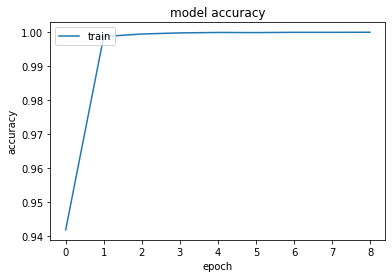

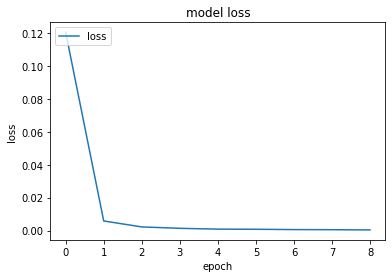

In [9]:
history = model.fit(train_dataset, epochs=100, shuffle=True, callbacks=[threshold_callback]) # , callbacks=[es]

plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left') #, 'validation'
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left') #, 'val_loss'
plt.show()

In [10]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, batch_size=16384)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 3s 453ms/step - loss: 9.2903e-05 - accuracy: 1.0000
test loss, test acc: [9.29034358705394e-05, 1.0]


In [11]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(32,32), color_mode="grayscale")
    
    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        plt.xlabel("Marked",fontsize=30)
    elif val == 0:
        plt.xlabel("Clear",fontsize=30)

In [12]:
# keras.models.save_model(
#     model, "/run/media/luka/221AE6131AE5E3AF/Users/User/MusterErkennung/", overwrite=True, include_optimizer=True, save_format=None,
#     signatures=None, options=None, save_traces=True
# )
# keras.models.save_model(
#     model, "/run/media/luka/FastDingDing/PythonProjects/MusterErkennung/classification_model/", overwrite=True, include_optimizer=True, save_format=None,
#     signatures=None, options=None, save_traces=True
# )
keras.models.save_model(
    model, "/home/luka/Documents/PythonProjects/MusterErkennung/classification_model/", overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

INFO:tensorflow:Assets written to: /home/luka/Documents/PythonProjects/MusterErkennung/classification_model/assets


2022-02-17 07:34:31.246433: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [13]:
model = tf.keras.models.load_model("/home/luka/Documents/PythonProjects/MusterErkennung/classification_model/")

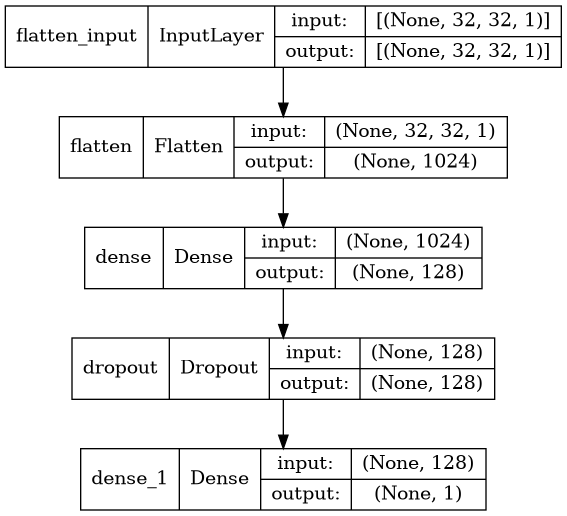

In [14]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

[[1.]]


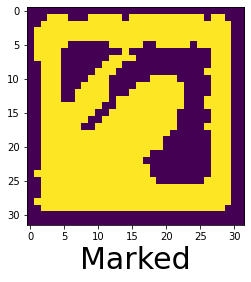

In [15]:
predictImage("/run/media/luka/FastDingDing/PythonProjects/MusterErkennung/anonymous_sheets/ml_class_images/testing/marked/SheetO_1_0_1d0.png")

[[0.]]


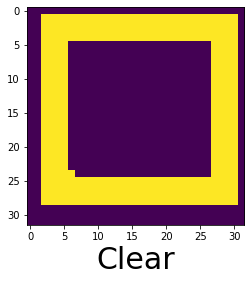

In [16]:
predictImage("/run/media/luka/FastDingDing/PythonProjects/MusterErkennung/anonymous_sheets/ml_class_images/testing/clear/SheetO_1_0_0d0.png")

[[1.]]


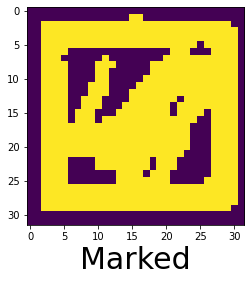

In [17]:
predictImage("/run/media/luka/FastDingDing/PythonProjects/MusterErkennung/anonymous_sheets/ml_class_images/testing/marked/SheetO_2_2_2d0.png")

[[0.]]


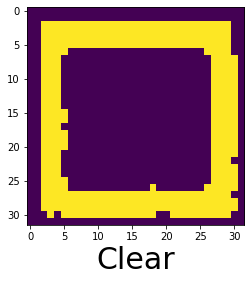

In [18]:
predictImage("/run/media/luka/FastDingDing/PythonProjects/MusterErkennung/anonymous_sheets/ml_class_images/testing/clear/SheetO_1_5_3d0.png")

[[1.]]


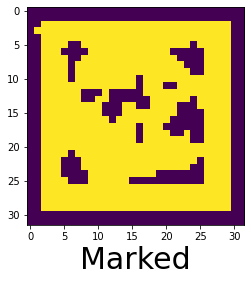

In [19]:
predictImage("/run/media/luka/FastDingDing/PythonProjects/MusterErkennung/anonymous_sheets/ml_class_images/testing/marked/SheetO_3_12_7d1.png")

[[0.]]


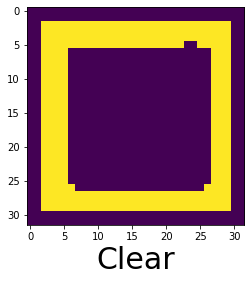

In [20]:
predictImage("/run/media/luka/FastDingDing/PythonProjects/MusterErkennung/anonymous_sheets/ml_class_images/testing/clear/SheetO_1_13_10d0.png")